# Week 8: Boundary Conditions and Code Exercises

This notebook explores different boundary conditions and implements the book exercises (7.2 and 7.5).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

## 1. Boundary Conditions Overview

### Periodic Boundary Conditions
- Used when the domain wraps around (e.g., circular domain)
- Grid spacing: $h = L/N$
- Left and right edges connect (wave re-enters from opposite side)

### Dirichlet Boundary Conditions
- Fixed values at boundaries
- Grid spacing: $h = L/(N-1)$
- Update only interior points: $a_1$ to $a_{N-2}$
- Boundaries $a_0$ and $a_{N-1}$ are specified

## 2. Example: Dirichlet Boundary Conditions (Exercise 7.2)

This implements a sinusoidal driving force at the left boundary with a fixed right boundary.

In [2]:
def advection_dirichlet(N=51, L=1.0, c=1.0, tau=0.02, nStep=50, omega=10*np.pi, method=3):
    """
    Solve advection equation with Dirichlet boundary conditions.
    Left boundary: sinusoidal driving a[0] = sin(omega*t)
    Right boundary: fixed a[-1] = 0
    """
    # Grid setup for Dirichlet
    h = L/(N-1)
    x = np.arange(N)*h - L/2.
    
    # Coefficients
    coeff = -c*tau/(2.*h)
    coefflw = 2*coeff**2
    
    print(f'Grid spacing: h = {h:.4f}')
    print(f'Time step: τ = {tau:.4f}')
    print(f'CFL number: c*τ/h = {c*tau/h:.4f}')
    print(f'Wave crosses system in {L/(c*tau):.1f} steps')
    
    # Initial condition: all zeros
    a = np.zeros(N)
    
    # Storage for plotting
    nplots = 20
    aplot = np.empty((N, nplots))
    tplot = np.empty(nplots)
    aplot[:,0] = a.copy()
    tplot[0] = 0
    plotStep = nStep//nplots + 1
    iplot = 1
    
    # Main time-stepping loop
    for iStep in range(nStep):
        # Set boundary conditions
        a[0] = np.sin(omega*tau*iStep)
        a[-1] = 0
        
        # Update interior points only
        if method == 1:  # FTCS
            a[1:-1] = a[1:-1] + coeff*(a[2:] - a[:-2])
        elif method == 2:  # Lax
            a[1:-1] = 0.5*(a[2:] + a[:-2]) + coeff*(a[2:] - a[:-2])
        elif method == 3:  # Lax-Wendroff
            a[1:-1] = a[1:-1] + coeff*(a[2:] - a[:-2]) + coefflw*(a[2:] + a[:-2] - 2*a[1:-1])
        else:  # Upwind
            a[1:-1] = a[1:-1] + 2*coeff*(a[1:-1] - a[:-2])
        
        # Store for plotting
        if (iStep+1) % plotStep < 1 and iplot < nplots:
            aplot[:,iplot] = a.copy()
            tplot[iplot] = tau*(iStep+1)
            iplot += 1
    
    return x, aplot, tplot, iplot

Grid spacing: h = 0.0200
Time step: τ = 0.0200
CFL number: c*τ/h = 1.0000
Wave crosses system in 50.0 steps


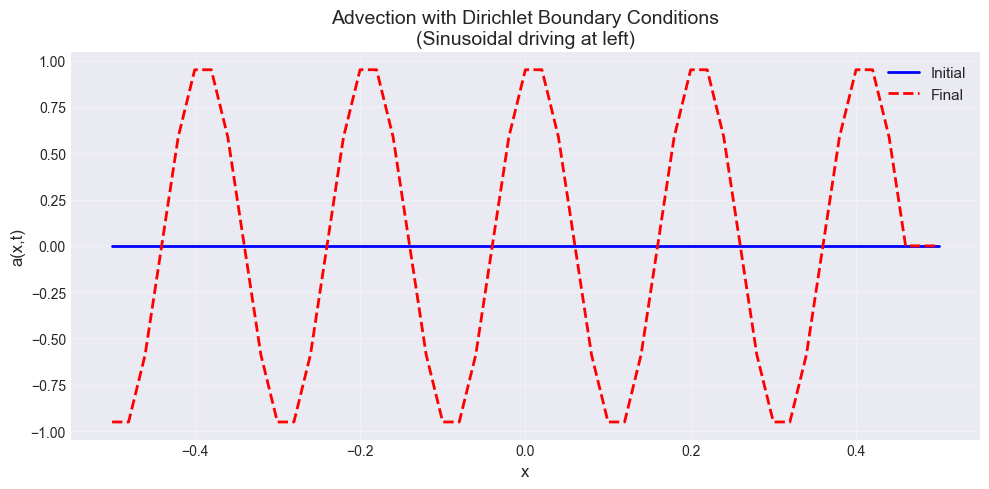

In [3]:
# Run the Dirichlet boundary condition example
x, aplot, tplot, iplot = advection_dirichlet()

# Plot initial and final states
plt.figure(figsize=(10, 5))
plt.plot(x, aplot[:,0], 'b-', label='Initial', linewidth=2)
plt.plot(x, aplot[:,iplot-1], 'r--', label='Final', linewidth=2)
plt.xlabel('x', fontsize=12)
plt.ylabel('a(x,t)', fontsize=12)
plt.title('Advection with Dirichlet Boundary Conditions\n(Sinusoidal driving at left)', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 3. Comparison: Periodic vs. Dirichlet

Let's visualize the key differences:

Grid spacing: h = 0.0200
Time step: τ = 0.0200
CFL number: c*τ/h = 1.0000
Wave crosses system in 50.0 steps


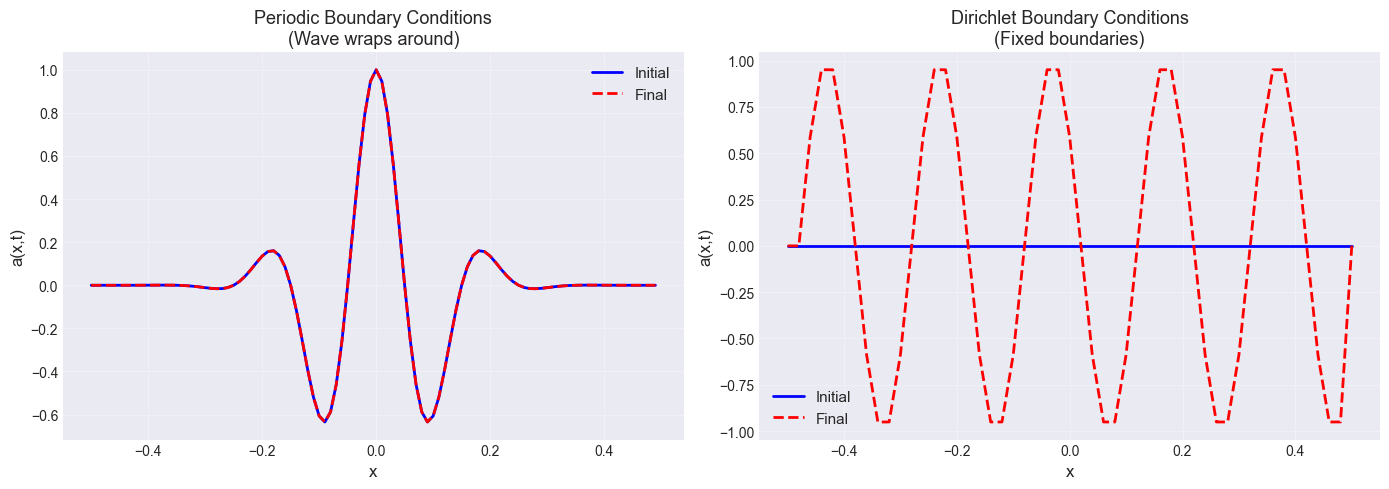

In [4]:
def advection_periodic(N=100, L=1.0, c=1.0, tau=0.01, nStep=100):
    """Advection with periodic boundary conditions."""
    h = L/N  # Note: L/N for periodic
    x = np.arange(N)*h - L/2.
    
    coeff = -c*tau/(2.*h)
    coefflw = 2*coeff**2
    
    # Initial Gaussian pulse
    sigma = 0.1
    k_wave = np.pi/sigma
    a = np.cos(k_wave*x) * np.exp(-x**2/(2*sigma**2))
    a_init = a.copy()
    
    # Periodic boundary indices
    ip = np.arange(N) + 1
    ip[N-1] = 0
    im = np.arange(N) - 1
    im[0] = N-1
    
    # Time-stepping (Lax-Wendroff)
    for iStep in range(nStep):
        a[:] = a[:] + coeff*(a[ip] - a[im]) + coefflw*(a[ip] + a[im] - 2*a[:])
    
    return x, a_init, a

# Compare both types
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Periodic BC
x_per, a_init_per, a_final_per = advection_periodic()
ax1.plot(x_per, a_init_per, 'b-', label='Initial', linewidth=2)
ax1.plot(x_per, a_final_per, 'r--', label='Final', linewidth=2)
ax1.set_xlabel('x', fontsize=12)
ax1.set_ylabel('a(x,t)', fontsize=12)
ax1.set_title('Periodic Boundary Conditions\n(Wave wraps around)', fontsize=13)
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Dirichlet BC
x_dir, aplot_dir, tplot_dir, iplot_dir = advection_dirichlet(nStep=100)
ax2.plot(x_dir, aplot_dir[:,0], 'b-', label='Initial', linewidth=2)
ax2.plot(x_dir, aplot_dir[:,iplot_dir-1], 'r--', label='Final', linewidth=2)
ax2.set_xlabel('x', fontsize=12)
ax2.set_ylabel('a(x,t)', fontsize=12)
ax2.set_title('Dirichlet Boundary Conditions\n(Fixed boundaries)', fontsize=13)
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Upwind Method (Exercise 7.5)

The upwind scheme is particularly useful for advection-dominated flows.

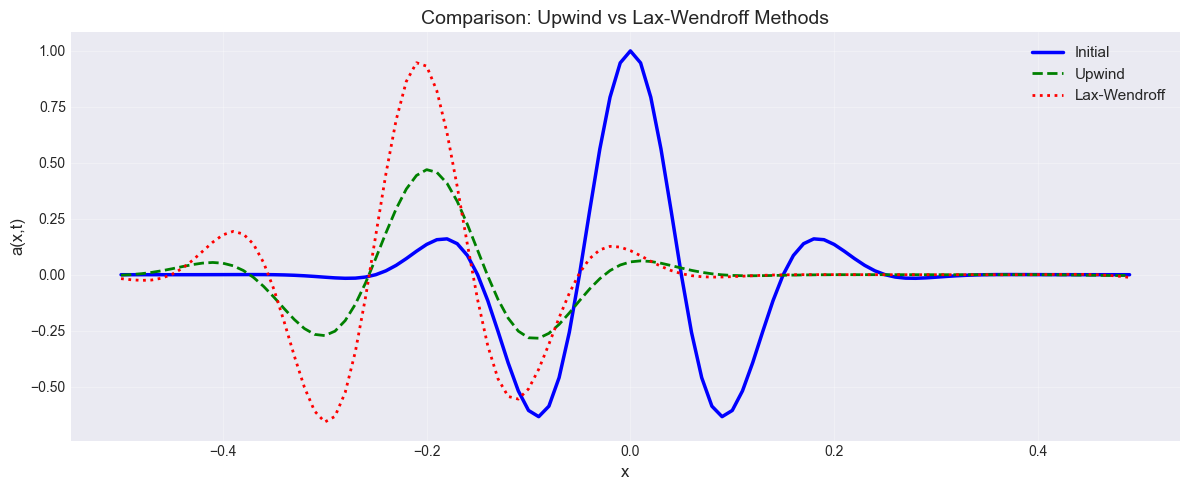


Observations:
• Upwind: More diffusive (wave spreads and dampens more)
• Lax-Wendroff: Better preserves wave shape and amplitude
• Trade-off: Upwind is more stable but less accurate


In [5]:
def compare_upwind_vs_lax_wendroff():
    """Compare upwind method with Lax-Wendroff."""
    N = 100
    L = 1.0
    c = 1.0
    tau = 0.008
    nStep = 100
    
    h = L/N
    x = np.arange(N)*h - L/2.
    coeff = -c*tau/(2.*h)
    coefflw = 2*coeff**2
    
    # Initial condition
    sigma = 0.1
    k_wave = np.pi/sigma
    a_init = np.cos(k_wave*x) * np.exp(-x**2/(2*sigma**2))
    
    # Periodic boundary indices
    ip = np.arange(N) + 1
    ip[N-1] = 0
    im = np.arange(N) - 1
    im[0] = N-1
    
    # Run Upwind
    a_upwind = a_init.copy()
    for iStep in range(nStep):
        a_upwind[:] = a_upwind[:] + 2*coeff*(a_upwind[:] - a_upwind[im])
    
    # Run Lax-Wendroff
    a_lw = a_init.copy()
    for iStep in range(nStep):
        a_lw[:] = a_lw[:] + coeff*(a_lw[ip] - a_lw[im]) + coefflw*(a_lw[ip] + a_lw[im] - 2*a_lw[:])
    
    return x, a_init, a_upwind, a_lw

# Compare methods
x, a_init, a_upwind, a_lw = compare_upwind_vs_lax_wendroff()

plt.figure(figsize=(12, 5))
plt.plot(x, a_init, 'b-', label='Initial', linewidth=2.5)
plt.plot(x, a_upwind, 'g--', label='Upwind', linewidth=2)
plt.plot(x, a_lw, 'r:', label='Lax-Wendroff', linewidth=2)
plt.xlabel('x', fontsize=12)
plt.ylabel('a(x,t)', fontsize=12)
plt.title('Comparison: Upwind vs Lax-Wendroff Methods', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("\nObservations:")
print("• Upwind: More diffusive (wave spreads and dampens more)")
print("• Lax-Wendroff: Better preserves wave shape and amplitude")
print("• Trade-off: Upwind is more stable but less accurate")

## 5. Interactive Parameter Study

Explore how different parameters affect the solution:

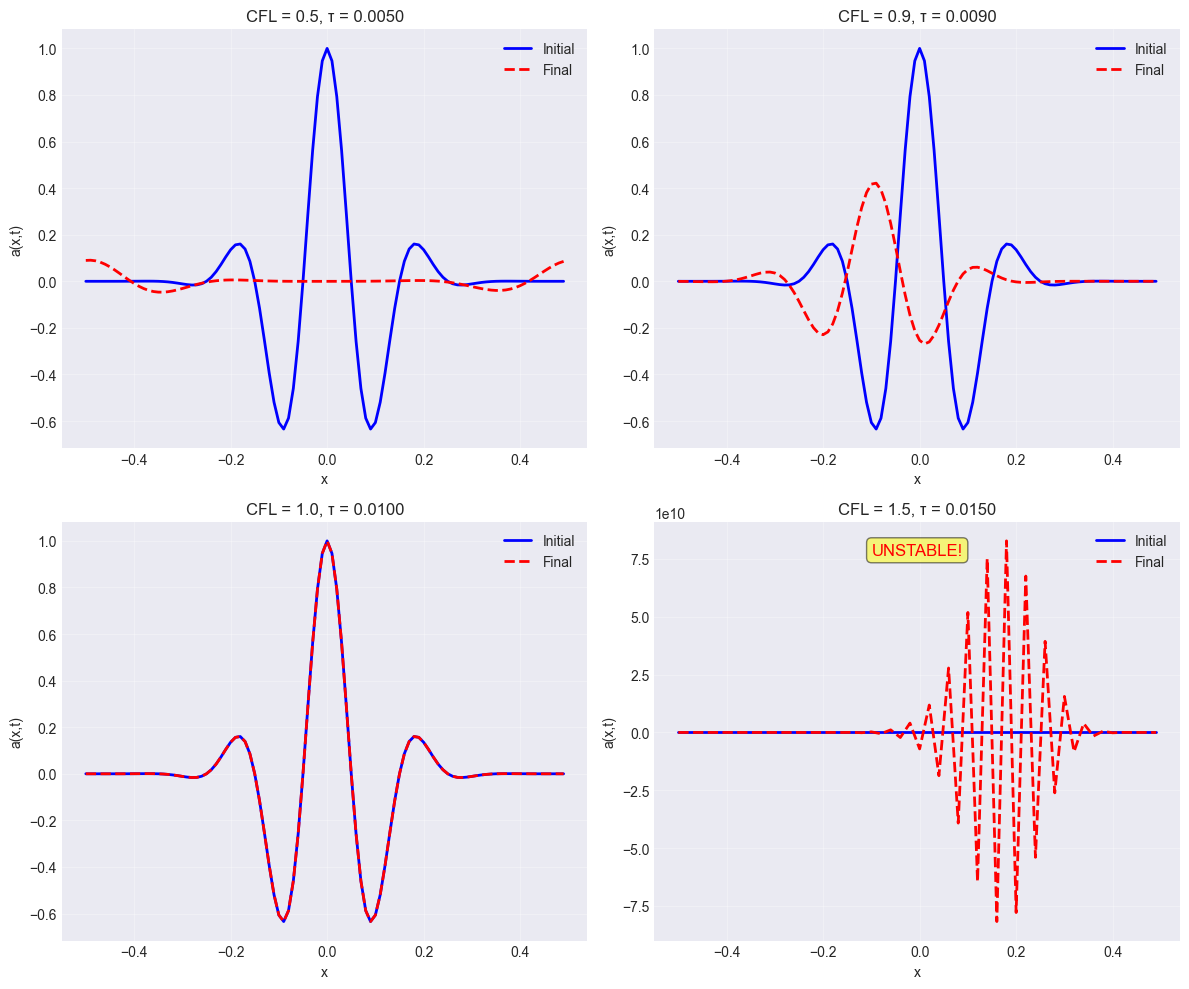


Key Insight: CFL Condition
• CFL ≤ 1: Stable solution
• CFL > 1: Instability develops (oscillations grow)
• CFL = 1: Optimal for Lax-Wendroff (equivalent to Lax)


In [6]:
def parameter_study():
    """Study effect of CFL number on stability."""
    N = 100
    L = 1.0
    c = 1.0
    nStep = 100
    
    # Different CFL numbers
    cfl_values = [0.5, 0.9, 1.0, 1.5]
    
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.flatten()
    
    for idx, cfl in enumerate(cfl_values):
        h = L/N
        tau = cfl * h / c
        x = np.arange(N)*h - L/2.
        
        coeff = -c*tau/(2.*h)
        coefflw = 2*coeff**2
        
        # Initial condition
        sigma = 0.1
        k_wave = np.pi/sigma
        a = np.cos(k_wave*x) * np.exp(-x**2/(2*sigma**2))
        a_init = a.copy()
        
        # Periodic boundary
        ip = np.arange(N) + 1
        ip[N-1] = 0
        im = np.arange(N) - 1
        im[0] = N-1
        
        # Lax method
        for iStep in range(nStep):
            a[:] = 0.5*(a[ip] + a[im]) + coeff*(a[ip] - a[im])
        
        axes[idx].plot(x, a_init, 'b-', label='Initial', linewidth=2)
        axes[idx].plot(x, a, 'r--', label='Final', linewidth=2)
        axes[idx].set_xlabel('x')
        axes[idx].set_ylabel('a(x,t)')
        axes[idx].set_title(f'CFL = {cfl:.1f}, τ = {tau:.4f}')
        axes[idx].legend()
        axes[idx].grid(True, alpha=0.3)
        
        if cfl > 1.0:
            axes[idx].text(0.5, 0.95, 'UNSTABLE!', transform=axes[idx].transAxes,
                         ha='center', va='top', fontsize=12, color='red',
                         bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.5))
    
    plt.tight_layout()
    plt.show()

parameter_study()

print("\nKey Insight: CFL Condition")
print("="*50)
print("• CFL ≤ 1: Stable solution")
print("• CFL > 1: Instability develops (oscillations grow)")
print("• CFL = 1: Optimal for Lax-Wendroff (equivalent to Lax)")

## 6. Summary of Boundary Conditions

| Boundary Type | Grid Spacing | When to Use | Considerations |
|--------------|--------------|-------------|----------------|
| **Periodic** | $h = L/N$ | Circular/wrapped domains | Wave re-enters from opposite side |
| **Dirichlet** | $h = L/(N-1)$ | Fixed boundary values | Specify $a_0$ and $a_{N-1}$ |
| **Neumann** | $h = L/(N-1)$ | Fixed flux at boundaries | Specify $\partial a/\partial x$ |

### Implementation Suggestions:

**Periodic BC:**
```python
ip = np.arange(N) + 1
ip[N-1] = 0  # Wrap around
im = np.arange(N) - 1
im[0] = N-1  # Wrap around
```

**Dirichlet BC:**
```python
# Set boundaries
a[0] = left_value
a[-1] = right_value
# Update only interior
a[1:-1] = ...
```

## 8. Summary

### Boundary Conditions Matter:
- Choice affects grid spacing formula
- Different physics require different BC types
- Always specify BC clearly in your code

### Stability is Critical:
- Always check CFL condition
- Monitor for growing oscillations
- Use appropriate time step

### Method Selection:
- **Lax-Wendroff:** Best accuracy for smooth solutions
- **Upwind:** Better for discontinuities (shocks)
- **Lax:** Good general-purpose method

### Common Issues:
- **Over-diffusion:** Wave spreads too much (reduce τ or use higher-order method)
- **Dispersion:** Spurious oscillations (check CFL, use Lax-Wendroff)
- **Instability:** Growing oscillations (reduce τ, check CFL condition)